In [1]:
import numpy as np
import seaborn as sns

In [2]:
bp_data = np.load('../../data/processed/BP_npy/PulseDB/test_sbp.npy')

# ラベリング関数の定義
def label_blood_pressure(bp):
    if bp <= 100:
        return 0    # 正常血圧
    elif 100 < bp < 120:
        return 1    # 正常血圧
    elif 120 < bp < 140:
        return 2    # 正常高値血圧
    else:
        return 3    # 高血圧

# ベクトル化した関数を作成
vectorized_label = np.vectorize(label_blood_pressure)

# データ全体にラベリングを適用
bp_labels = vectorized_label(bp_data)

In [10]:
print("ラベルの分布:")
unique, counts = np.unique(bp_labels, return_counts=True)
for label, count in zip(unique, counts):
    print(f"ラベル {label}: {count}件")

ラベルの分布:
ラベル 0: 20674件
ラベル 1: 41043件
ラベル 2: 32447件
ラベル 3: 17436件


In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import wandb
from sklearn.metrics import f1_score
from resnet1d import ResNet1D

In [3]:
from resnet1d import ResNet1D
config = {
    "network":{
        "in_channels":1,
        "base_filters":64,
        "kernel_size":3,
        "stride":1,
        "groups":1,
        "n_block":5,
        "n_classes":4,
    },
    "learning_rate": 1e-3,
    "batch_size": 32,
    "epochs":100,
    "log_interval":100,
    "input_shape":[1,1250],
    "output_path": "..\\outputs\\resnet\\0304_4classes",
    "patience":10    
          }
model = ResNet1D(**config["network"])

In [4]:
model.load_state_dict(torch.load('..\\outputs\\resnet\\0304_4class\\best.pth'))
model.to(device)
model.eval()


NameError: name 'device' is not defined

In [20]:
torch._utils


AttributeError: module 'torch' has no attribute '_utils'

### dataset

In [ ]:
from resnet1d import ResNet1D
config = {
    "network":{
        "in_channels":1,
        "base_filters":64,
        "kernel_size":3,
        "stride":1,
        "groups":1,
        "n_block":5,
        "n_classes":2,
    },
    "learning_rate": 1e-3,
    "batch_size": 32,
    "epochs":100,
    "log_interval":100,
    "input_shape":[1,1250],
    "output_path": "..\\outputs\\resnet\\0408_2class_cv_res18",
    "patience":10    
          }
model = ResNet1D(**config["network"])

In [26]:
class BPDataset(Dataset):
    def __init__(self, data_dir,train=True):
        # Load data
        if train:
            self.x = np.load(f'{data_dir}/train.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            self.y = np.load(f'{data_dir}/train_sbp_2labels.npy')  # Shape: (-1,)
            # self.x = np.load(f'{data_dir}/train_2.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            # self.y = np.load(f'{data_dir}/train_sbp_2labels.npy')  # Shape: (-1,)
        else:
            self.x = np.load(f'{data_dir}/test.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            self.y = np.load(f'{data_dir}/test_sbp_2labels.npy')  # Shape: (-1,)
            # self.x = np.load(f'{data_dir}/test_2.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            # self.y = np.load(f'{data_dir}/test_sbp_2labels.npy')  # Shape: (-1,)
        
        # Convert to torch tensors
        self.x = torch.FloatTensor(self.x)
        self.y = torch.LongTensor(self.y)
        print(self.x.shape,self.y.shape)
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]


In [41]:
# データセットとDataLoaderの作成
data_dir = '../../data/processed/BP_npy/PulseDB'
batch_size = 32

# train_dataset = BPDataset(data_dir,train=True)
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BPDataset(data_dir,train=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# トレーニングデータの確認
# x, y = train_dataset[0]
# print("Training data:")
# print(f"x shape: {x.shape}, x dtype: {x.dtype}")
# print(f"y shape: {y.shape}, y dtype: {y.dtype}")
# print(f"Unique labels in training: {torch.unique(train_dataset.y)}")

# テストデータの確認
x, y = test_dataset[0]
print("\nTest data:")
print(f"x shape: {x.shape}, x dtype: {x.dtype}")
print(f"y shape: {y.shape}, y dtype: {y.dtype}")
print(f"Unique labels in test: {torch.unique(test_dataset.y)}")

torch.Size([111600, 1, 1250]) torch.Size([111600])

Test data:
x shape: torch.Size([1, 1250]), x dtype: torch.float32
y shape: torch.Size([]), y dtype: torch.int64
Unique labels in test: tensor([0, 1, 2, 3])


In [7]:
def calculate_metrics(y_true, y_pred,classes=2):
        # 正解率
        accuracy = np.mean(y_true == y_pred)
        
        # クラスごとの精度を計算
        class_accuracies = []
        for cls in range(classes):
            mask = (y_true == cls)
            if np.sum(mask) > 0:
                class_acc = np.sum((y_true == y_pred) & mask) / np.sum(mask)
                class_accuracies.append(class_acc)
            else:
                raise ValueError(f"Class {cls} has no samples.")
        
        # マクロ平均F1スコア
        f1_macro = f1_score(y_true, y_pred, average='macro')
        
        return accuracy, class_accuracies, f1_macro

## test

In [42]:
all_y_true = []
all_y_pred = []
val_loader_tqdm = tqdm(test_dataloader, desc=f"Epoch {1 + 1}/{100} - Validation", leave=False)
with torch.no_grad():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for batch_idx, (x,y) in enumerate(val_loader_tqdm):

        x,y = x.to(device), y.to(device)
        outputs = model(x)
        # loss_mae = mae(outputs, gt)
        # if batch_idx % config.log_interval == 0:
        #     wandb.log({"test_loss_step": loss.item()})
        # # if batch_idx  == 0:
        # #     wandb.log({"val/loss": log_img(gt,outputs)})
        # val_loss += loss.item()
        # val_loss_mae += loss_mae.item()
        _, predicted = torch.max(outputs.data, 1)
        all_y_true.extend(y.cpu().numpy())
        all_y_pred.extend(predicted.cpu().numpy())
all_y_true = np.array(all_y_true)
all_y_pred = np.array(all_y_pred)
accuracy, class_accuracies, f1 = calculate_metrics(all_y_true, all_y_pred,classes=config["network"]["n_classes"])


In [43]:
accuracy,f1

(0.39923835125448026, 0.4017165782090687)

In [44]:
from sklearn.metrics import confusion_matrix
import pandas as pd
pd.options.display.precision = 4 # 表示桁数の設定

conf_mat = confusion_matrix(all_y_true, all_y_pred, normalize='true')
display(pd.DataFrame(conf_mat))

,0,1,2,3
0,0.5670,0.2666,0.1104,0.0560
1,0.3329,0.3401,0.2336,0.0934
2,0.1592,0.2853,0.3589,0.1966
3,0.0864,0.1514,0.3476,0.4145


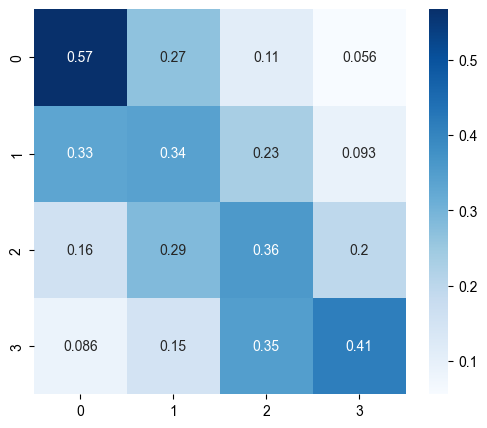

In [45]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Arial' # フォントを指定
import seaborn as sns

plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, cmap = 'Blues', annot=True)
plt.show()

## cv


In [9]:
config = {
    "network":{
        "in_channels":1,
        "base_filters":64,
        "kernel_size":3,
        "stride":1,
        "groups":1,
        "n_block":5,
        "n_classes":2,
    },
    "learning_rate": 1e-4,
    "batch_size": 16,
    "epochs":100,
    "log_interval":100,
    "input_shape":[1,1250],
    "output_path": "..\\outputs\\resnet\\0415_2class_cv_res18mini",
    "patience":5    
}

In [10]:
from se_resnet1d import resnet34,se_resnet34,resnet18,resnet18mini
model = resnet18mini(num_classes=config["network"]["n_classes"], in_channels=config["network"]["in_channels"])

In [11]:
from dataset import BPDataset
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import wandb
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
data_dir = '../../data/processed/BP_npy/PulseDB'
checkpoint_dir =config["output_path"]
batch_size = config["batch_size"]
test_dataset = BPDataset(data_dir,train=False)
f1s = []
for fold in range(5):
    # データセットとDataLoaderの作成
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    # load checkpoint
    checkpoint_path = os.path.join(checkpoint_dir, f'best_fold{fold}.pth')
    model.load_state_dict(torch.load(checkpoint_path))
    with torch.no_grad():
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        model.eval()

        all_y_true = []
        all_y_pred = []
        all_y_pred_proba = []
        # 進捗バーの設定
        val_loader_tqdm = tqdm(test_dataloader, desc=f"Fold {fold+1}/{5} - Test", leave=False)
        for batch_idx, (x,y) in enumerate(val_loader_tqdm):
            x,y = x.to(device), y.to(device)
            outputs = model(x)
            _, predicted = torch.max(outputs.data, 1)
            all_y_pred_proba.extend(outputs.cpu().numpy())
            # 予測確率を取得
            all_y_true.extend(y.cpu().numpy())
            all_y_pred.extend(predicted.cpu().numpy())
        all_y_true = np.array(all_y_true)
        all_y_pred = np.array(all_y_pred)
        all_y_pred_proba = np.array(all_y_pred_proba)
    # 予測結果の保存
    np.save(f'{checkpoint_dir}\\predictions_fold{fold}.npy', all_y_pred)
    # 正解ラベルの保存
    np.save(f'{checkpoint_dir}\\true_labels_fold{fold}.npy', all_y_true)
    # 予測確率の保存
    np.save(f'{checkpoint_dir}\\predictions_proba_fold{fold}.npy', all_y_pred_proba)
    # calculate metrics
    accuracy, class_accuracies, f1 = calculate_metrics(all_y_true, all_y_pred,classes=config["network"]["n_classes"])
    print(f"Fold {fold+1} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    f1s.append(f1)
    # plot confusion matrix
    conf_mat = confusion_matrix(all_y_true, all_y_pred, normalize='true')
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_mat, cmap = 'Blues', annot=True)
    plt.title(f'Fold {fold+1} - Confusion Matrix')
    plt.savefig(f'{checkpoint_dir}\\confusion_matrix_fold{fold}.png')
    plt.close()
print(np.array(f1s).mean())

torch.Size([38110, 1, 1250]) torch.Size([38110])


Fold 1 - Accuracy: 0.8047, F1 Score: 0.8038


Fold 2 - Accuracy: 0.7993, F1 Score: 0.7986


Fold 3 - Accuracy: 0.8003, F1 Score: 0.7991


Fold 4 - Accuracy: 0.7971, F1 Score: 0.7967


Fold 5 - Accuracy: 0.8072, F1 Score: 0.8065
0.8009534138368508


### load test results

In [12]:
def metrics_all_fold(checkpoint_dir, n_classes=2):
    accuracy_list = []
    f1_list = []
    for fold in range(5):
        # load predictions
        all_y_pred = np.load(f'{checkpoint_dir}\\predictions_fold{fold}.npy')
        all_y_true = np.load(f'{checkpoint_dir}\\true_labels_fold{fold}.npy')
        accuracy, class_accuracies, f1 = calculate_metrics(all_y_true, all_y_pred, classes=n_classes)
        accuracy_list.append(accuracy)
        f1_list.append(f1)
        print(f"Fold {fold+1} - Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")
    return accuracy_list, f1_list

In [13]:
checkpoint_dir = config["output_path"]
n_classes = config["network"]["n_classes"]

In [18]:
print("Metrics for",os.path.basename(checkpoint_dir))
accuracy_list, f1_list = metrics_all_fold(checkpoint_dir, n_classes=n_classes)

Metrics for 0331_2class_cv_res34
Fold 1 - Accuracy: 0.8230, F1 Score: 0.8214
Fold 2 - Accuracy: 0.8024, F1 Score: 0.8013
Fold 3 - Accuracy: 0.7932, F1 Score: 0.7910
Fold 4 - Accuracy: 0.8056, F1 Score: 0.8043
Fold 5 - Accuracy: 0.7991, F1 Score: 0.7971


In [ ]:
me

In [20]:
fold = 0

pred = np.load(f'{checkpoint_dir}\\predictions_fold{fold}.npy')
pred_proba = np.load(f'{checkpoint_dir}\\predictions_proba_fold{fold}.npy')
true_labels = np.load(f'{checkpoint_dir}\\true_labels_fold{fold}.npy')




### check sSqi

In [25]:
correct = np.where(pred == true_labels)[0]
incorrect = np.where(pred != true_labels)[0]
test_data = np.load(f'../../data/processed/BP_npy/PulseDB/test_2.npy')

Text(0.5, 1.0, 'Skewness of Correct and Incorrect Predictions')

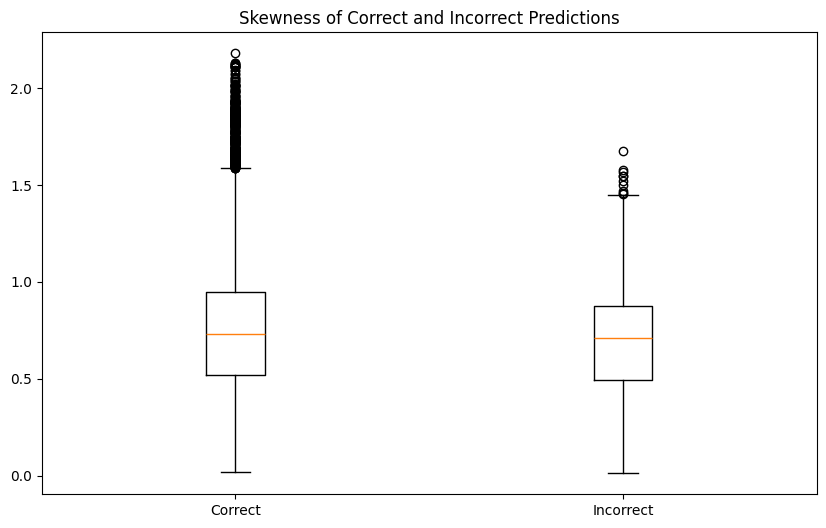

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt
skew_correct = stats.skew(test_data[correct,1], axis=1)
skew_incorrect = stats.skew(test_data[incorrect,1], axis=1)
# boxplot
plt.figure(figsize=(10, 6))
plt.boxplot([skew_correct, skew_incorrect], labels=['Correct', 'Incorrect'])
plt.title('Skewness of Correct and Incorrect Predictions')


In [37]:
print(np.std(skew_correct),np.std(skew_incorrect))

0.3212311642498526 0.27149631551984976


In [36]:
from scipy.stats import ttest_ind

# aとbが独立した群で正規分布前提
stat, p = ttest_ind(skew_correct, skew_incorrect, equal_var=False)  # Welchのt検定
print("p値:", p)

p値: 2.5041297039384584e-66


In [38]:
from scipy.stats import shapiro

# aとbが1次元のデータ配列
stat_a, p_a = shapiro(skew_correct)
stat_b, p_b = shapiro(skew_incorrect)

print("aのShapiro検定 p値:", p_a)
print("bのShapiro検定 p値:", p_b)

if p_a > 0.05:
    print("aは正規分布とみなせる")
else:
    print("aは正規分布とは言えない")

if p_b > 0.05:
    print("bは正規分布とみなせる")
else:
    print("bは正規分布とは言えない")

aのShapiro検定 p値: 0.0
bのShapiro検定 p値: 9.768134825480321e-17
aは正規分布とは言えない
bは正規分布とは言えない


f:\minowa\BloodPressureEstimation\.venv\lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [30]:
def calculate_correlation(data):
    n = data.shape[0]
    correlations = np.zeros(n)
    for a in range(n):
        # Compute the correlation coefficient between data[a, 0, :] and data[a, 1, :]
        corr = np.corrcoef(data[a, 1, :], data[a, 0, :])[0, 1]
        correlations[a] = corr
    
    return correlations

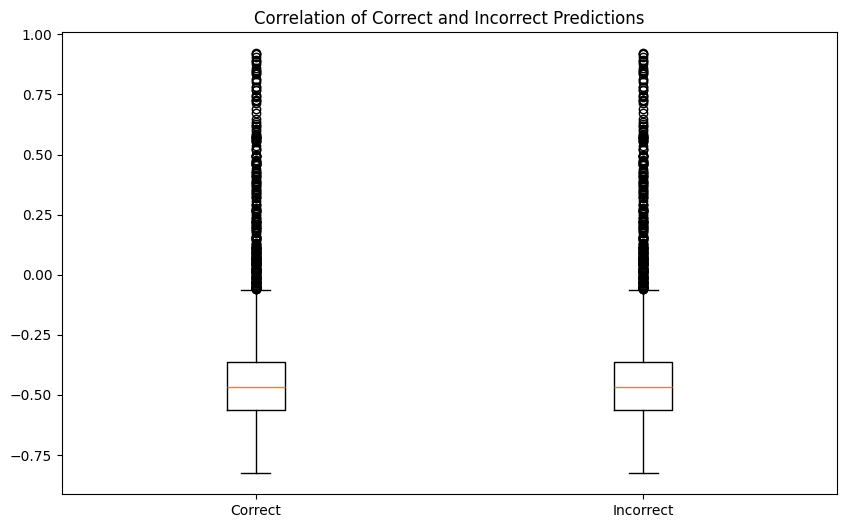

In [31]:
# 相関係数
corr_correct = calculate_correlation(test_data[correct])
corr_incorrect = corr_correct = calculate_correlation(test_data[incorrect])
plt.figure(figsize=(10, 6))
plt.boxplot([corr_correct, corr_incorrect], labels=['Correct', 'Incorrect'])
plt.title('Correlation of Correct and Incorrect Predictions')
plt.show()

### count number

In [21]:
np.unique(true_labels, return_counts=True)

(array([0, 1], dtype=int64), array([20674, 17436], dtype=int64))

In [ ]:
Fold 1 - Accuracy: 0.7960, F1 Score: 0.7960
                                                                     
Fold 2 - Accuracy: 0.7850, F1 Score: 0.7850
                                                                     
Fold 3 - Accuracy: 0.8000, F1 Score: 0.7997
                                                                     
Fold 4 - Accuracy: 0.8054, F1 Score: 0.8051
                                                                     
Fold 5 - Accuracy: 0.8072, F1 Score: 0.8071

# regr


In [112]:
class BPDataset_Regr(Dataset):
    def __init__(self, data_dir,train=True):
        # Load data
        if train:
            self.x = np.load(f'{data_dir}/train.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            self.sbp = np.load(f'{data_dir}/train_sbp.npy')  # Shape: (-1,)
            self.dbp = np.load(f'{data_dir}/train_dbp.npy')  # Shape: (-1,)
            # self.x = np.load(f'{data_dir}/train_2.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            # self.y = np.load(f'{data_dir}/train_sbp_2labels.npy')  # Shape: (-1,)
        else:
            self.x = np.load(f'{data_dir}/test.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            self.sbp = np.load(f'{data_dir}/test_sbp.npy')  # Shape: (-1,)
            self.dbp = np.load(f'{data_dir}/test_dbp.npy')  # Shape: (-1,)
            # self.x = np.load(f'{data_dir}/test_2.npy')[:, 1, :].reshape(-1,1,1250)  # Shape: (-1, 1250)
            # self.y = np.load(f'{data_dir}/test_sbp_2labels.npy')  # Shape: (-1,)
        scale = np.load(f'{data_dir}/scale_train.npy')
        self.sbp = self.sbp * scale[0,1]- scale[0,0]
        self.dbp = self.dbp * scale[0,1] - scale[0,0]

        # Convert to torch tensors
        self.x = torch.FloatTensor(self.x)
        self.sbp = torch.FloatTensor(self.sbp)
        self.dbp = torch.FloatTensor(self.dbp)
        print(self.x.shape,self.sbp.shape,self.dbp.shape)
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        return self.x[idx], self.sbp[idx],self.dbp[idx]


In [113]:
# データセットとDataLoaderの作成
data_dir = '../../data/processed/BP_npy/PulseDB'
batch_size = 32

# train_dataset = BPDataset(data_dir,train=True)
# train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = BPDataset_Regr(data_dir,train=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


torch.Size([111600, 1, 1250]) torch.Size([111600]) torch.Size([111600])


In [116]:
config = {
    "network":{
        "in_channels":1,
        "base_filters":64,
        "kernel_size":3,
        "stride":1,
        "groups":1,
        "n_block":5,
        "n_classes":2,
    },
    "learning_rate": 1e-3,
    "batch_size": batch_size,
    "epochs":100,
    "log_interval":100,
    "input_shape":[1,1250],
    "output_path": "..\\outputs\\resnet\\0308_regr",
    "patience":10    
          }

In [117]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNet1D(**config["network"])
model.load_state_dict(torch.load('..\\outputs\\resnet\\0308_regr\\best_fold0.pth'))
model.to(device)
model.eval()

RuntimeError: Error(s) in loading state_dict for ResNet1D:
	size mismatch for first_block_conv.conv.weight: copying a param with shape torch.Size([64, 1, 5]) from checkpoint, the shape in current model is torch.Size([64, 1, 3]).
	size mismatch for basicblock_list.0.conv1.conv.weight: copying a param with shape torch.Size([64, 64, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 3]).
	size mismatch for basicblock_list.0.conv2.conv.weight: copying a param with shape torch.Size([64, 64, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 3]).
	size mismatch for basicblock_list.1.conv1.conv.weight: copying a param with shape torch.Size([64, 64, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 3]).
	size mismatch for basicblock_list.1.conv2.conv.weight: copying a param with shape torch.Size([64, 64, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 3]).
	size mismatch for basicblock_list.2.conv1.conv.weight: copying a param with shape torch.Size([64, 64, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 3]).
	size mismatch for basicblock_list.2.conv2.conv.weight: copying a param with shape torch.Size([64, 64, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 3]).
	size mismatch for basicblock_list.3.conv1.conv.weight: copying a param with shape torch.Size([64, 64, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 3]).
	size mismatch for basicblock_list.3.conv2.conv.weight: copying a param with shape torch.Size([64, 64, 5]) from checkpoint, the shape in current model is torch.Size([64, 64, 3]).
	size mismatch for basicblock_list.4.conv1.conv.weight: copying a param with shape torch.Size([128, 64, 5]) from checkpoint, the shape in current model is torch.Size([128, 64, 3]).
	size mismatch for basicblock_list.4.conv2.conv.weight: copying a param with shape torch.Size([128, 128, 5]) from checkpoint, the shape in current model is torch.Size([128, 128, 3]).

In [22]:
config["epochs"] 

100

In [25]:
val_loader = test_dataloader
all_y_true = []
all_y_pred = []
val_loader_tqdm = tqdm(val_loader)
with torch.no_grad():
    for batch_idx, (x,sbp,dbp) in enumerate(val_loader_tqdm):

        x,sbp,dbp = x.to(device), sbp.to(device),dbp.to(device)
        outputs = model(x)
        # val_loss_mae += loss_mae.item()
        all_y_true.extend(np.array([sbp.cpu().numpy(),dbp.cpu().numpy()]))
        all_y_pred.extend(np.array([outputs[:,0].cpu().numpy(),outputs[:,1].cpu().numpy()]))
all_y_true = np.concatenate(all_y_true,axis=0).reshape(-1,2)
all_y_pred = np.concatenate(all_y_pred,axis=0).reshape(-1,2)
# print(all_y_true.shape,all_y_pred.shape)
# accuracy, class_accuracies, f1 = calculate_metrics(all_y_true, all_y_pred,classes=config["network"]["n_classes"])


100%|██████████| 3488/3488 [00:15<00:00, 219.69it/s]


In [3]:
import numpy as np
scale = np.load('../../data/processed/BP_npy/PulseDB/scale_train.npy')
1/scale[0,1]

284.2411394163927

In [ ]:
error = (all_y_true - all_y_pred)
scale = np.load('../../data/processed/BP_npy/PulseDB/scale_train.npy')
error = (error - scale[0,0])/scale[0,1]
error[1]

NameError: name 'all_y_true' is not defined

In [35]:
error.shape

(111600, 2)

In [38]:
error_5.shape

(111600,)

In [39]:

mse = np.mean(error**2,axis=0)
rmse = np.sqrt(mse)
me = np.mean(error,axis=0)
mae = np.mean(np.abs(error),axis=0)
std = np.std(error,axis=0)
n_samples = len(test_dataset)
(me.shape,mae.shape,rmse.shape,std.shape)
error_5 = np.count_nonzero(np.abs(error)<=5,axis=0)/n_samples*100
error_15 = np.count_nonzero(np.abs(error)<=15,axis=0)/n_samples*100
error_10 = np.count_nonzero(np.abs(error)<=10,axis=0)/n_samples*100

In [40]:
print("""
          test data samples:
          # samples : {}
          
          Eval Stats:   DBP    SBP
          MAE:        {:6.3f} {:6.3f}
          RMSE:       {:6.3f} {:6.3f}
          Mean Error: {:6.3f} {:6.3f}
          STD:        {:6.3f} {:6.3f}
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP     {:5.1f}%  {:5.1f}%  {:5.1f}%
          SBP     {:5.1f}%  {:5.1f}%  {:5.1f}%
           
          
          """.format(
            n_samples,
            *mae,
            *rmse,
            *me,
            *std,
            error_5[0], error_10[0], error_15[0],
            error_5[1], error_10[1], error_15[1],
          ))


          test data samples:
          # samples : 111600
          
          Eval Stats:   DBP    SBP
          MAE:        11.901 11.929
          RMSE:       15.566 15.606
          Mean Error:  3.869  3.949
          STD:        15.078 15.098
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP      27.7%   52.3%   70.7%
          SBP      27.8%   52.1%   70.5%
           
          
          


# Grad-CAM


In [118]:
class GradCAM:
    def __init__(self, model, feature_layer):
        self.model = model
        self.feature_layer = feature_layer
        self.model.eval()
        self.feature_grad = None
        self.feature_map = None
        self.hooks = []

        # 最終層逆伝播時の勾配を記録する
        def save_feature_grad(module, in_grad, out_grad):
            self.feature_grad = out_grad[0]
        self.hooks.append(self.feature_layer.register_backward_hook(save_feature_grad))

        # 最終層の出力 Feature Map を記録する
        def save_feature_map(module, inp, outp):
            self.feature_map = outp[0]
        self.hooks.append(self.feature_layer.register_forward_hook(save_feature_map))

    def forward(self, x):
        return self.model(x)

    def backward_on_target(self, output, target):
        self.model.zero_grad()
        one_hot_output = torch.zeros([1, output.size()[-1]],device=output.device)
        one_hot_output[0][target] = 0
        output.backward(gradient=one_hot_output, retain_graph=True)

    def clear_hook(self):
        for hook in self.hooks:
            hook.remove()

In [18]:
from resnet1d import ResNet1D
config = {
    "network":{
        "in_channels":1,
        "base_filters":64,
        "kernel_size":3,
        "stride":1,
        "groups":1,
        "n_block":5,
        "n_classes":2,
    },
    "learning_rate": 1e-3,
    "batch_size": 32,
    "epochs":100,
    "log_interval":100,
    "input_shape":[1,1250],
    "output_path": "..\\outputs\\resnet\\0228",
    "patience":10    
          }
model = ResNet1D(**config["network"])

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
model.load_state_dict(torch.load('..\\outputs\\resnet\\0228\\best.pth'))
model.to(device)
model.eval()



ResNet1D(
  (first_block_conv): MyConv1dPadSame(
    (conv): Conv1d(1, 64, kernel_size=(3,), stride=(1,))
  )
  (first_block_bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (first_block_relu): ReLU()
  (basicblock_list): ModuleList(
    (0-3): 4 x BasicBlock(
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (do1): Dropout(p=0.5, inplace=False)
      (conv1): MyConv1dPadSame(
        (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      )
      (bn2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (do2): Dropout(p=0.5, inplace=False)
      (conv2): MyConv1dPadSame(
        (conv): Conv1d(64, 64, kernel_size=(3,), stride=(1,))
      )
      (max_pool): MyMaxPool1dPadSame(
        (max_pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (4): BasicBlock(
      (bn1): 

In [13]:
id_to_label = {0: 'normal', 1: 'high'}


In [14]:
grad_cam = 

SyntaxError: invalid syntax (1291206013.py, line 1)

In [27]:
data_dir = '../../data/processed/BP_npy/PulseDB'
batch_size = 32

test_dataset = BPDataset(data_dir,train=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


torch.Size([111600, 1, 1250]) torch.Size([38110])


In [53]:
def plot_cam(cam, y,title=None):
    y=y.squeeze()
    heatmap_image = np.tile(cam, (20, 1))  # 高さ20ピクセル相当のストライプ
    fig, ax = plt.subplots(figsize=(10, 4))
    x = np.arange(0,10,0.008)
    # imshowで背景にヒートマップを表示
    ax.imshow(
        heatmap_image,
        extent=[x.min(), x.max(), y.min() - 0.1, y.max() + 0.1],
        aspect='auto',
        cmap='RdYlBu_r',
        alpha=0.5,  # 透明度
        origin='lower'
    )
    ax.set_title(title)
    # 波形のプロット
    ax.plot(x, y, color='black')
    ax.set_xlim(x.min(), x.max())
    plt.tight_layout()
    plt.show()


In [68]:
def grad_cam_plot(model,idx):
    grad_cam = GradCAM(model=model, feature_layer=model.basicblock_list[-1])
    input_tensor = test_dataset[idx][0].unsqueeze(0).to(device)
    print("true:",test_dataset[idx][1].cpu().numpy(),"pred:",grad_cam.forward(input_tensor),nn.Softmax(dim=1)(grad_cam.forward(input_tensor)))
    model_output = grad_cam.forward(input_tensor)
    target = model_output.argmax(1).item()
    grad_cam.backward_on_target(model_output, target)
    # Get feature gradient
    feature_grad = grad_cam.feature_grad.data.cpu().numpy()[0]
    print(feature_grad.shape)
    # Get weights from gradient
    weights = np.mean(feature_grad, axis=1)  # Take averages for each gradient
    # Get features outputs
    feature_map = grad_cam.feature_map.data.cpu().numpy()
    grad_cam.clear_hook()
    cam = np.sum((weights * feature_map.T), axis=1).T
    cam = np.maximum(cam, 0)  # apply ReLU to cam
    cam = (cam-cam.min())/(cam.max()-cam.min())
    plot_cam(cam,input_tensor.cpu().numpy()[0],title=f"true:{test_dataset[idx][1].cpu().numpy()},pred:{nn.Softmax(dim=1)(grad_cam.forward(input_tensor)).detach().cpu().numpy()[0]}")

In [ ]:
i = np.random.randint(10000)
print(i)
grad_cam_plot(model,i)

257


RuntimeError: Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same

: 

In [65]:
plot_cam(cam,input_tensor.cpu().numpy()[0])

NameError: name 'cam' is not defined

In [ ]:
import heartpy as hp



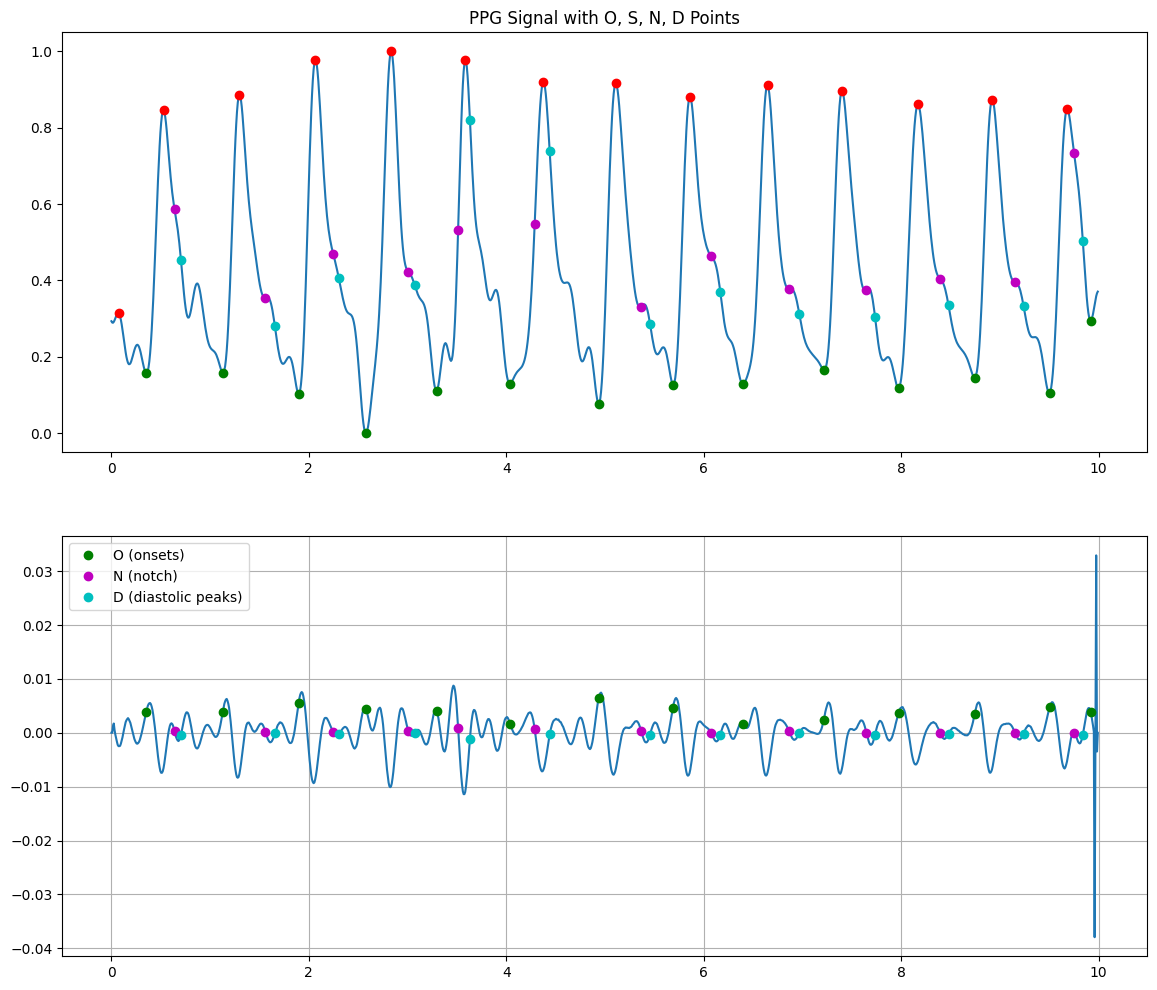

In [90]:
import numpy as np
from scipy.signal import find_peaks
import matplotlib.pyplot as plt

# サンプルのPPG波形（例としてsin波 + ノイズ）
x = test_dataset[0][0].cpu().numpy().squeeze()
# --- 平滑化（移動平均） ---
def moving_average(x, n=5):
    return np.convolve(x, np.ones(n)/n, mode='same')

y = moving_average(x, n=5)

# --- JPG (3次差分の導関数) ---
def compute_jpg(y):
    # 差分
    d = np.zeros_like(y)
    for i in range(3, len(y)-2):
        d[i] = y[i+2] - 2*y[i+1] + 2*y[i] - y[i-1]
    # 微分
    jpg = np.gradient(d)
    return jpg

jpg = compute_jpg(y)

# --- 極大値 (S) と 極小値 (O) の検出 ---
peaks_s, _ = find_peaks(x, distance=50)
peaks_o, _ = find_peaks(-x, distance=50)

# --- ゼロクロス検出（N, D候補） ---
def zero_crossings(signal):
    return np.where(np.diff(np.sign(signal)))[0]

zc = zero_crossings(jpg)
# pairs = [(o, s) for o in peaks_o for s in peaks_s if o < s]
peaks_n = []
peaks_d = []
peaks_s_in_cycle = []

# O の連続するペアを使って区間を作る
for i in range(len(peaks_o) - 1):
    o_start = peaks_o[i]
    o_end = peaks_o[i + 1]

    # O–O区間にあるS（systolic peak）の中で最大のピーク（たいてい1個）
    s_candidates = [s for s in peaks_s if o_start < s < o_end]
    if len(s_candidates) == 0:
        continue  # Sが見つからなければスキップ
    peak_s = max(s_candidates, key=lambda idx: x[idx])
    peaks_s_in_cycle.append(peak_s)

    # O–O区間のJPGゼロクロス（NとDを探す）
    zc_in_range = [z for z in zc if o_start < z < o_end]
    if len(zc_in_range) >= 4:
        peaks_n.append(zc_in_range[2])
        peaks_d.append(zc_in_range[3])
    else:
        peaks_n.append(np.nan)
        peaks_d.append(np.nan)
# # N, Dとしてゼロクロスの3番目と4番目を仮で抽出
# peaks_n = zc[2::4]  # 3番目
# peaks_d = zc[3::4]  # 4番目
t=np.arange(0,10,0.008)
# --- プロット ---
plt.figure(figsize=(14, 12))
plt.subplot(2,1,1)
plt.plot(t, x, label='PPG Signal')
plt.plot(t[peaks_s], x[peaks_s], 'ro', label='S (systolic peaks)')
plt.plot(t[peaks_o], x[peaks_o], 'go', label='O (onsets)')
plt.plot(t[peaks_n], x[peaks_n], 'mo', label='N (notch)')
plt.plot(t[peaks_d], x[peaks_d], 'co', label='D (diastolic peaks)')
plt.title('PPG Signal with O, S, N, D Points')
plt.subplot(2,1,2)
plt.plot(t,jpg)
plt.plot(t[peaks_o], jpg[peaks_o], 'go', label='O (onsets)')
plt.plot(t[peaks_n], jpg[peaks_n], 'mo', label='N (notch)')
plt.plot(t[peaks_d], jpg[peaks_d], 'co', label='D (diastolic peaks)')
plt.legend()
plt.grid(True)
plt.show()


resnet34 7,219,266,
seresnet34 7,376,450
resnet18 3,844,930
seresnet18 3,931,970

In [4]:
from torchinfo import summary
from se_resnet1d import resnet34,se_resnet34,se_resnet18,resnet18
model = resnet18(num_classes=config["network"]["n_classes"], in_channels=config["network"]["in_channels"])
summary(model, input_size=(1, 1, 1250), col_names=["input_size", "output_size", "num_params", "trainable"], row_settings=["var_names"])

Layer (type (var_name))                  Input Shape               Output Shape              Param #                   Trainable
ResNet1D (ResNet1D)                      [1, 1, 1250]              [1, 2]                    --                        True
├─Conv1d (conv1)                         [1, 1, 1250]              [1, 64, 625]              448                       True
├─BatchNorm1d (bn1)                      [1, 64, 625]              [1, 64, 625]              128                       True
├─ReLU (relu)                            [1, 64, 625]              [1, 64, 625]              --                        --
├─MaxPool1d (maxpool)                    [1, 64, 625]              [1, 64, 313]              --                        --
├─Sequential (layer1)                    [1, 64, 313]              [1, 64, 313]              --                        True
│    └─BasicBlock (0)                    [1, 64, 313]              [1, 64, 313]              --                        True
│    │ 